# Mohammad Amin Rami

# Student ID: 98101588
## Deep Learning HW3
## Question 1

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Part A

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
label_map = {0:'Boot', 1:'Sandal', 2:'Shoe'}
size = (100, 132)


In [3]:
transform = transforms.Compose([
    transforms.CenterCrop(size),
    transforms.ToTensor()
])

images = ImageFolder(
    root='Shoe vs Sandal vs Boot Dataset/',
    transform=lambda im: transform(im).to(device),
    target_transform=lambda y: torch.tensor(y).to(device)
)

idx = int(0.7*len(images))

train_index, test_index = train_test_split([i for i in range(len(images))], test_size=0.3)

train_set = Subset(images, train_index)
test_set = Subset(images, test_index)

train_loader = DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=16,
    shuffle=True
)

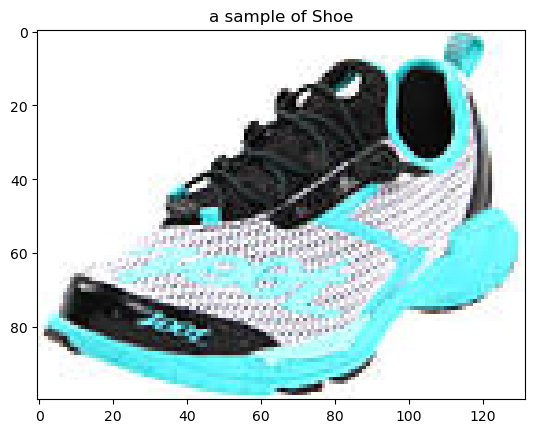

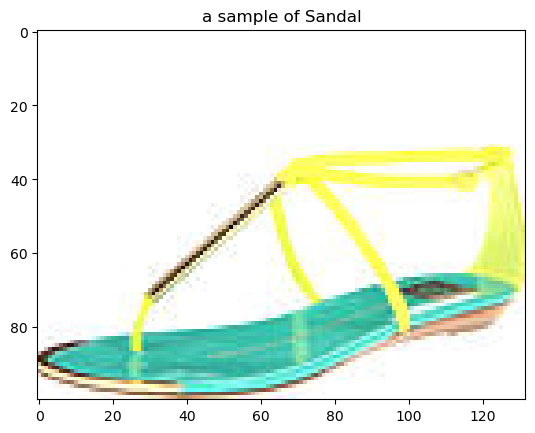

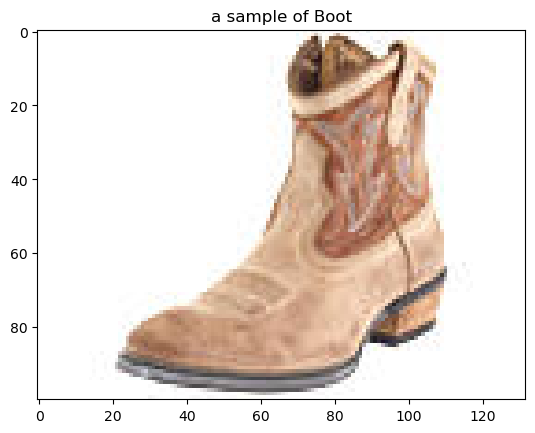

In [4]:
has_not_appeared = [True, True, True]
train_iter = iter(train_set)
while any(has_not_appeared):
    data = next(train_iter)
    im = data[0]
    label = data[1].item()
    
    if has_not_appeared[label]:
        has_not_appeared[label] = False
        plt.imshow(im.cpu().numpy().transpose(1, 2, 0))
        plt.title(f'a sample of {label_map[label]}')
        plt.show()
    

### Part B

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpl = nn.AvgPool2d(kernel_size=4)
        self.flatten = nn.Flatten()
        self.relu_stack = nn.Sequential(
            nn.Linear(25*33*3, 1000),
            nn.ReLU(),
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
    
    def forward(self, x):
        x = self.avgpl(x)
        x = self.flatten(x)
        x = self.relu_stack(x)
        return x

In [6]:
def get_number_of_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    overall_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        overall_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return overall_loss/num_batches

In [8]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [9]:
mlp_model = MLP().to(device)
mlp_model.train()

MLP(
  (avgpl): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu_stack): Sequential(
    (0): Linear(in_features=2475, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [10]:
learning_rate = 1e-2
max_epochs = 10

loss_fn = nn.CrossEntropyLoss()
mlp_optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

writer = SummaryWriter()


In [11]:
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loss = train_loop(train_loader, mlp_model, loss_fn, mlp_optimizer)
    test_acc = test_loop(test_loader, mlp_model, loss_fn)
    writer.add_scalar('Loss/train', train_loss, epoch)
print("Done!")

writer.flush()
writer.close()

Epoch 1
-------------------------------
loss: 1.092106  [    0/10500]
loss: 1.094533  [ 1600/10500]
loss: 1.080656  [ 3200/10500]
loss: 1.037674  [ 4800/10500]
loss: 0.872640  [ 6400/10500]
loss: 0.565831  [ 8000/10500]
loss: 0.996433  [ 9600/10500]
Test Error: 
 Test Accuracy: 73.1%, Avg loss: 0.623213 

Epoch 2
-------------------------------
loss: 0.542381  [    0/10500]
loss: 0.849312  [ 1600/10500]
loss: 0.672026  [ 3200/10500]
loss: 0.348739  [ 4800/10500]
loss: 0.713128  [ 6400/10500]
loss: 0.646859  [ 8000/10500]
loss: 0.678135  [ 9600/10500]
Test Error: 
 Test Accuracy: 58.6%, Avg loss: 0.937139 

Epoch 3
-------------------------------
loss: 1.053548  [    0/10500]
loss: 0.178720  [ 1600/10500]
loss: 0.444066  [ 3200/10500]
loss: 0.426007  [ 4800/10500]
loss: 0.839273  [ 6400/10500]
loss: 0.172002  [ 8000/10500]
loss: 0.354335  [ 9600/10500]
Test Error: 
 Test Accuracy: 70.1%, Avg loss: 0.713530 

Epoch 4
-------------------------------
loss: 0.867294  [    0/10500]
loss: 0.3

In [12]:
def test_all(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    y = torch.tensor([]).to(device)
    pred = torch.tensor([]).to(device)

    with torch.no_grad():
        for X, y_batch in dataloader:
            pred = torch.cat((pred, model(X).argmax(dim=1)), dim=0)
            y = torch.cat((y, y_batch), dim=0)
    return y, pred

===== Report for class Boot =====
precision: 0.95
recall: 0.92
===== Report for class Sandal =====
precision: 0.92
recall: 0.87
===== Report for class Shoe =====
precision: 0.86
recall: 0.95
----------------------------------------
number of parameters: 2769379
----------------------------------------
Confusion matrix:


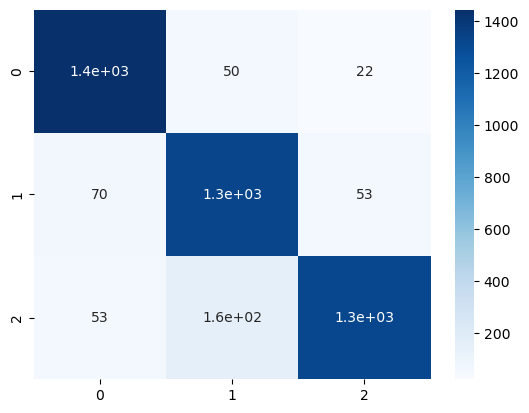

In [13]:
y, pred = test_all(test_loader, mlp_model)
conf_mat = confusion_matrix(y.cpu(), pred.cpu())

for i in range(3):
    precision = conf_mat[i, i]/sum(conf_mat[i, :])
    recall = conf_mat[i, i]/sum(conf_mat[:, i])
    
    print(f'===== Report for class {label_map[i]} =====')
    print(f'precision: {precision:0.2f}')
    print(f'recall: {recall:0.2f}')
    

print('-'*40)
print(f'number of parameters: {get_number_of_params(mlp_model)}')

print('-'*40)
sns.heatmap(conf_mat, annot=True, cmap='Blues')
print('Confusion matrix:')

### Part C

In [14]:
# TODO

### Part D

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpl = nn.AvgPool2d(kernel_size=4)
        
        self.s1 = nn.Sequential(
            nn.Conv2d(3, 512, 3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.s2 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.s3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.s4 = nn.Sequential(
            nn.Conv2d(128, 32, 3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.s5 = nn.Sequential(
            nn.Conv2d(32, 8, 3, padding='same'),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.relu_stack = nn.Sequential(
            nn.Linear(25*33*8, 80),
            nn.ReLU(),
            nn.Linear(80, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
        
    def forward(self, x):
        x = self.avgpl(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)
        x = self.s5(x)
        x = self.flatten(x)
        x = self.relu_stack(x)
        return x

In [16]:
cnn = CNN().to(device)
cnn.train()

CNN(
  (avgpl): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (s1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (s2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (s3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (s4): Sequential(
    (0): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (s5): Sequential(
    (0): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(8, eps=1e

In [17]:
learning_rate = 1e-4
max_epochs = 10

loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [18]:
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, cnn, loss_fn, cnn_optimizer)
    test_acc = test_loop(test_loader, cnn, loss_fn)
    if test_acc >= 0.97:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.097950  [    0/10500]
loss: 0.274777  [ 1600/10500]
loss: 0.105414  [ 3200/10500]
loss: 0.290196  [ 4800/10500]
loss: 0.395928  [ 6400/10500]
loss: 0.434734  [ 8000/10500]
loss: 0.310247  [ 9600/10500]
Test Error: 
 Test Accuracy: 95.3%, Avg loss: 0.136739 

Epoch 2
-------------------------------
loss: 0.150706  [    0/10500]
loss: 0.148072  [ 1600/10500]
loss: 0.009684  [ 3200/10500]
loss: 0.191687  [ 4800/10500]
loss: 0.027767  [ 6400/10500]
loss: 0.121219  [ 8000/10500]
loss: 0.344425  [ 9600/10500]
Test Error: 
 Test Accuracy: 95.0%, Avg loss: 0.142634 

Epoch 3
-------------------------------
loss: 0.341008  [    0/10500]
loss: 0.027368  [ 1600/10500]
loss: 0.021615  [ 3200/10500]
loss: 0.003257  [ 4800/10500]
loss: 0.019408  [ 6400/10500]
loss: 0.099637  [ 8000/10500]
loss: 0.013749  [ 9600/10500]
Test Error: 
 Test Accuracy: 97.1%, Avg loss: 0.089683 

Done!


===== Report for class Boot =====
precision: 0.98
recall: 0.98
===== Report for class Sandal =====
precision: 0.97
recall: 0.96
===== Report for class Shoe =====
precision: 0.96
recall: 0.97
----------------------------------------
number of parameters: 2059787
----------------------------------------
Confusion matrix:


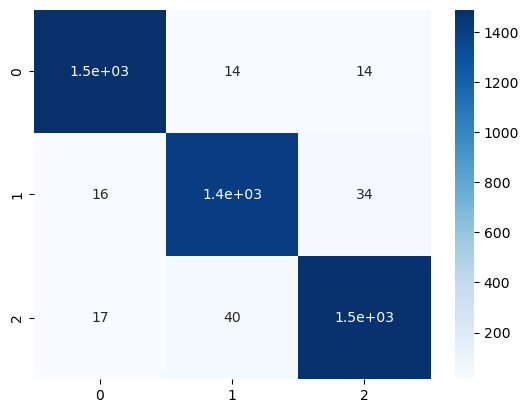

In [19]:
y, pred = test_all(test_loader, cnn)
conf_mat = confusion_matrix(y.cpu(), pred.cpu())

for i in range(3):
    precision = conf_mat[i, i]/sum(conf_mat[i, :])
    recall = conf_mat[i, i]/sum(conf_mat[:, i])
    
    print(f'===== Report for class {label_map[i]} =====')
    print(f'precision: {precision:0.2f}')
    print(f'recall: {recall:0.2f}')
    

print('-'*40)
print(f'number of parameters: {get_number_of_params(cnn)}')

print('-'*40)
sns.heatmap(conf_mat, annot=True, cmap='Blues')
print('Confusion matrix:')

### Part E

Comparison between CNN and MLP Model:
CNN has a much better performance compared to MLP.    
CNN has an aprrozimate accuracy of 97%     
MLP has an approximate accuracy of 84%     

### Part F

In [20]:
class CNNWithDropout(CNN):
    def __init__(self):
        super().__init__()
        self.s1 = nn.Sequential(
            nn.Conv2d(3, 512, 3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout()
        )
        
        self.s3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout()
        )
        
        self.s5 = nn.Sequential(
            nn.Conv2d(32, 8, 3, padding='same'),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout()
        )
        
        self.relu_stack = nn.Sequential(
            nn.Linear(25*33*8, 80),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(80, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )


In [21]:
cnn_dp = CNNWithDropout().to(device)
cnn_dp.train()

CNNWithDropout(
  (avgpl): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (s1): Sequential(
    (0): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (s2): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (s3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (s4): Sequential(
    (0): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (s5): Sequential(
    (0): Conv

In [22]:
learning_rate = 1e-4
max_epochs = 10

loss_fn = nn.CrossEntropyLoss()
cnn_dp_optimizer = torch.optim.Adam(cnn_dp.parameters(), lr=learning_rate)

In [23]:
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, cnn_dp, loss_fn, cnn_dp_optimizer)
    test_acc = test_loop(test_loader, cnn_dp, loss_fn)
    if test_acc >= 0.96:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.165482  [    0/10500]
loss: 0.565190  [ 1600/10500]
loss: 0.434549  [ 3200/10500]
loss: 0.323516  [ 4800/10500]
loss: 0.340616  [ 6400/10500]
loss: 0.222998  [ 8000/10500]
loss: 0.175400  [ 9600/10500]
Test Error: 
 Test Accuracy: 90.5%, Avg loss: 0.278039 

Epoch 2
-------------------------------
loss: 0.608188  [    0/10500]
loss: 0.238014  [ 1600/10500]
loss: 0.274223  [ 3200/10500]
loss: 0.137989  [ 4800/10500]
loss: 0.209656  [ 6400/10500]
loss: 0.045080  [ 8000/10500]
loss: 0.068415  [ 9600/10500]
Test Error: 
 Test Accuracy: 94.4%, Avg loss: 0.169075 

Epoch 3
-------------------------------
loss: 0.057404  [    0/10500]
loss: 0.048002  [ 1600/10500]
loss: 0.068558  [ 3200/10500]
loss: 0.044223  [ 4800/10500]
loss: 0.030482  [ 6400/10500]
loss: 0.023628  [ 8000/10500]
loss: 0.171801  [ 9600/10500]
Test Error: 
 Test Accuracy: 94.5%, Avg loss: 0.157427 

Epoch 4
-------------------------------
loss: 0.037803  [    0/10500]
loss: 0.2

===== Report for class Boot =====
precision: 0.98
recall: 0.97
===== Report for class Sandal =====
precision: 0.95
recall: 0.97
===== Report for class Shoe =====
precision: 0.96
recall: 0.96
----------------------------------------
number of parameters: 2059787
----------------------------------------
Confusion matrix:


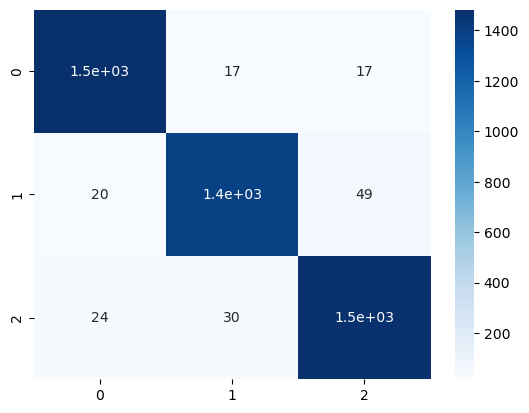

In [24]:
y, pred = test_all(test_loader, cnn_dp)
conf_mat = confusion_matrix(y.cpu(), pred.cpu())

for i in range(3):
    precision = conf_mat[i, i]/sum(conf_mat[i, :])
    recall = conf_mat[i, i]/sum(conf_mat[:, i])
    
    print(f'===== Report for class {label_map[i]} =====')
    print(f'precision: {precision:0.2f}')
    print(f'recall: {recall:0.2f}')
    

print('-'*40)
print(f'number of parameters: {get_number_of_params(cnn_dp)}')

print('-'*40)
sns.heatmap(conf_mat, annot=True, cmap='Blues')
print('Confusion matrix:')

### Part G

In [25]:
class CNNWithFactorization(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpl = nn.AvgPool2d(kernel_size=4)
        
        self.s1 = nn.Sequential(
            nn.Conv2d(3, 256, (3, 1), padding='same'),
            nn.Conv2d(256, 256, (1, 3), padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.s2 = nn.Sequential(
            nn.Conv2d(256, 128, (3, 1), padding='same'),
            nn.Conv2d(128, 128, (1, 3), padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.s3 = nn.Sequential(
            nn.Conv2d(128, 32, (3, 1), padding='same'),
            nn.Conv2d(32, 32, (1, 3), padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.s4 = nn.Sequential(
            nn.Conv2d(32, 8, (3, 1), padding='same'),
            nn.Conv2d(8, 8, (1, 3), padding='same'),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.relu_stack = nn.Sequential(
            nn.Linear(25*33*8, 80),
            nn.ReLU(),
            nn.Linear(80, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
        
    def forward(self, x):
        x = self.avgpl(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)
        x = self.flatten(x)
        x = self.relu_stack(x)
        return x

In [30]:
cnn_fr = CNNWithFactorization().to(device)
cnn_fr.train()

CNNWithFactorization(
  (avgpl): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (s1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 1), stride=(1, 1), padding=same)
    (1): Conv2d(256, 256, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (s2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 1), stride=(1, 1), padding=same)
    (1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (s3): Sequential(
    (0): Conv2d(128, 32, kernel_size=(3, 1), stride=(1, 1), padding=same)
    (1): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (s4): Sequential(
    (0): Conv2d(32, 8, kernel_size=(3, 1), stride=(1, 1), padding=s

In [31]:
learning_rate = 1e-4
max_epochs = 10

loss_fn = nn.CrossEntropyLoss()
cnn_fr_optimizer = torch.optim.Adam(cnn_fr.parameters(), lr=learning_rate)

In [32]:
for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(train_loader, cnn_fr, loss_fn, cnn_fr_optimizer)
    test_acc = test_loop(test_loader, cnn_fr, loss_fn)
    if test_acc >= 0.96:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 1.088481  [    0/10500]
loss: 0.376314  [ 1600/10500]
loss: 0.267463  [ 3200/10500]
loss: 0.176974  [ 4800/10500]
loss: 0.296779  [ 6400/10500]
loss: 0.070836  [ 8000/10500]
loss: 0.164072  [ 9600/10500]
Test Error: 
 Test Accuracy: 93.8%, Avg loss: 0.173819 

Epoch 2
-------------------------------
loss: 0.075763  [    0/10500]
loss: 0.247089  [ 1600/10500]
loss: 0.130920  [ 3200/10500]
loss: 0.076285  [ 4800/10500]
loss: 0.093432  [ 6400/10500]
loss: 0.030624  [ 8000/10500]
loss: 0.280401  [ 9600/10500]
Test Error: 
 Test Accuracy: 95.6%, Avg loss: 0.121640 

Epoch 3
-------------------------------
loss: 0.081963  [    0/10500]
loss: 0.073551  [ 1600/10500]
loss: 0.104559  [ 3200/10500]
loss: 0.216675  [ 4800/10500]
loss: 0.169426  [ 6400/10500]
loss: 0.059756  [ 8000/10500]
loss: 0.016417  [ 9600/10500]
Test Error: 
 Test Accuracy: 96.3%, Avg loss: 0.109106 

Done!


===== Report for class Boot =====
precision: 0.98
recall: 0.98
===== Report for class Sandal =====
precision: 0.92
recall: 0.99
===== Report for class Shoe =====
precision: 0.99
recall: 0.93
----------------------------------------
number of parameters: 893811
----------------------------------------
Confusion matrix:


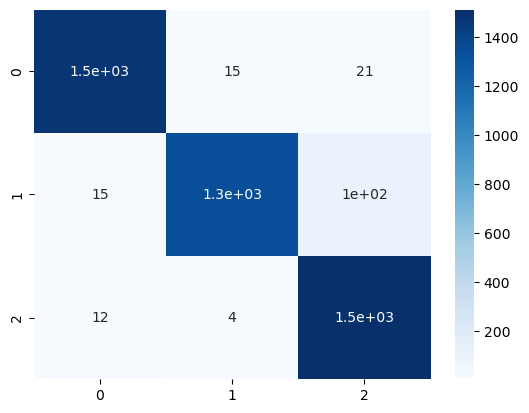

In [33]:
y, pred = test_all(test_loader, cnn_fr)
conf_mat = confusion_matrix(y.cpu(), pred.cpu())

for i in range(3):
    precision = conf_mat[i, i]/sum(conf_mat[i, :])
    recall = conf_mat[i, i]/sum(conf_mat[:, i])
    
    print(f'===== Report for class {label_map[i]} =====')
    print(f'precision: {precision:0.2f}')
    print(f'recall: {recall:0.2f}')
    

print('-'*40)
print(f'number of parameters: {get_number_of_params(cnn_fr)}')

print('-'*40)
sns.heatmap(conf_mat, annot=True, cmap='Blues')
print('Confusion matrix:')

### Comparison:
As we can see, by using kernel factorization, the number of parameters have decreased from 2059878 to 893811    
Having less parameters has the following advantages:      
    1. Because we have less parameters, our model takes less time to be trained     
    2. Havling less parameters causes the model to be less prune to overfitting    